In [22]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math

In [23]:
def forward_selection(data, significance_level=0.01): #Selecting significant features, removing TEAM, CONF and W:G manually
  
  target = data["W:G"].to_numpy()
  features = data.columns.tolist()
  lowest_p_value = 0
  lowest_p_index = -1
  for i in range(len(features)):
    if (features[i] == "TEAM" or features[i] == "CONF" or features[i] == "W:G"):
      continue
    X = data.loc[:, features[i]]
    X = sm.add_constant(X)
    result = sm.OLS(target, X.astype(float)).fit()
    curr_p_value = result.pvalues[1]
    if lowest_p_index == -1 or lowest_p_value > curr_p_value:
        lowest_p_value = curr_p_value
        lowest_p_index = i

  removed_features = [data.loc[:, features.pop(lowest_p_index)].name]
  while (True):
      lowest_p_value = 0
      lowest_p_index = -1
      for i in range(len(features)):
        if (features[i] == "TEAM" or features[i] == "CONF" or features[i] == "W:G"):
          continue
        removed_features.append(features[i])
        X = data.loc[:, removed_features]
        X = sm.add_constant(X)
        result = sm.OLS(target, X.astype(float)).fit()
        removed_features.remove(features[i])
        curr_value = result.pvalues[len(result.pvalues) - 1]
        if lowest_p_index == -1 or lowest_p_value > curr_value:
            lowest_p_value = curr_value
            lowest_p_index = i
    
      if (lowest_p_value >= significance_level):
        return removed_features
      else:
        if (len(features) == 0):
            break
        removed_features.append(features.pop(lowest_p_index))
          
  return removed_features

In [24]:
def top_features(columns, size): # Return the most important features from forward selection
    return columns[:size]

In [25]:
def linear_regression(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [26]:
def display_summary(results):
    print(results.summary())

In [27]:
"""
Load the preprocessed dataset
"""
csv_name = 'cleaned_cbb.csv'
data = pd.read_csv(csv_name)

In [28]:
"""
Select the top features from forward selection
"""
fwd_sel = forward_selection(data)
important_features = top_features(fwd_sel, 5)
print(important_features)
X = data[important_features]
y = data["W:G"]

['ADJOE', 'WAB', 'EFG_O', 'TOR', 'ORB']


In [29]:
"""
Split the dataset into a training and testing set
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
"""
Perform supervised learning to predict the win rate using selected features with Ordinary Linear Regression
"""
model = linear_regression(X_train, y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    W:G   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          2.578e+04
Date:                Wed, 20 Apr 2022   Prob (F-statistic):                        0.00
Time:                        14:25:44   Log-Likelihood:                          2555.7
No. Observations:                1964   AIC:                                     -5101.
Df Residuals:                    1959   BIC:                                     -5074.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ADJOE         -0.0120      0.000    -26.339      0.000      -0.013      -0.011
WAB            0.0206      0.000     70.724      0.000       0.020       0.021
EFG_O          0.0356      0.001     39.537      0.000       0.034       0.037
TOR           -0.0132      0.001    -14.719      0.000      -0.015      -0.011
ORB            0.0127      0.001     24.185      0.000       0.012       0.014
==============================================================================
Omnibus:                        2.295   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                2.134
Skew:                           0.005   Prob(JB):                        0.344
Kurtosis:                       2.839   Cond. No.                         100.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
"""
Training MSE
"""
metrics.mean_squared_error(y_train, model.predict(X_train))

0.004337607092675051

In [32]:
"""
Test MSE
"""
metrics.mean_squared_error(y_test, model.predict(X_test))

0.004402449588294065

In [33]:
"""
Calculate performance of the model on a test dataset
"""
predicted = model.predict(X_test)
print(metrics.r2_score(y_test, predicted))
metrics.explained_variance_score(y_test, predicted)

0.8632602779137972


0.8643059860065809

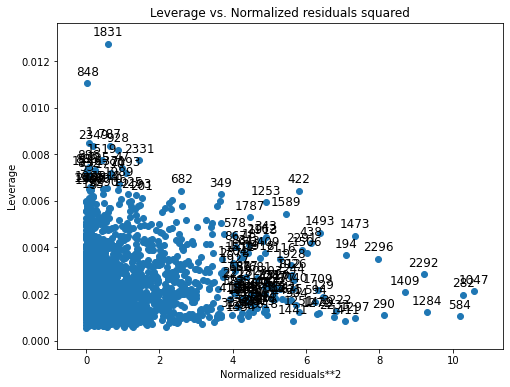

In [34]:
"""
Plot the influence of residuals on the model
"""
test_class = OLSInfluence(model)
test_class.dfbetas[:5, :]
fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(model, ax=ax)

In [35]:
"""
Figure out the top teams in the 2021 season
"""
csv_name = 'cbb21.csv'
data = pd.read_csv(csv_name)

X = data[important_features]

predicted = model.predict(X)
data['SCORE'] = predicted

order = list(reversed(np.argsort(predicted)))

# Print top 10 teams
print(data.loc[order[:10], ['TEAM', 'SCORE']])

                  TEAM     SCORE
3              Gonzaga  1.016834
1               Baylor  0.950238
2             Illinois  0.930538
54             Colgate  0.883021
49            Winthrop  0.851237
0             Michigan  0.845196
45               Drake  0.831841
31      Loyola Chicago  0.824511
316  Stephen F. Austin  0.823829
22                 USC  0.801104


In [ ]:
"""
Actual top teams in the 2021 season

Gonzaga
Houston
Kansas
Arizona
Baylor
Villanova
Tennessee
Texas Tech
Kentucky
Duke
"""